## Загрузка библиотек и вводные

In [165]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

**Текст задания:** \
Напишите скрипт на Python, получающий данные из HTML таблицы с данными по рождаемости в России (ссылка ниже) и визуализируйте их на графике. Готовый файл в формате .ipynb загрузите на любой файлообменник, а в поле ответа укажите ссылку.

In [166]:
URL = 'https://worldtable.info/gosudarstvo/tablica-rozhdaemosti-po-godam-rossija.html'

In [167]:
# создаем корпоративную палитру
rgb = [(14, 227, 255), (0, 251, 0)]
colors = [tuple(t / 255 for t in x) for x in rgb]

## Парсинг с сайта

Сначала напишем функцию для парсинга HTML таблицу, которую еще и можно будет использовать в будущем.

In [168]:
def parse_html_tables(url: str) -> list[pd.DataFrame]:
    import requests
    from bs4 import BeautifulSoup

    # get the response and turn it to a list of html tables
    response = requests.get(url)                         
    soup = BeautifulSoup(response.text, 'html.parser')
    html_tables = soup.find_all('table')
    
    # turn every html table into pandas data frame
    tables = []
    for html_table in html_tables:
        
        # get the content of a table
        html_table_caption = html_table.find('caption').text
        html_table_body = html_table.find('tbody')

        # turn html rows into list of listsy
        rows = []
        for html_row in html_table_body.find_all('tr'):
            row = [value.text for value in html_row.find_all('td')]
            rows.append(row)
        
        # turn a list into pd data frame and set headers as the frist row
        table = pd.DataFrame(rows)
        table.columns = table.iloc[0]
        table = table[1:]
        
        tables.append({'table': table, 'caption': html_table_caption})
        
    return tables

## Визуализируем данные

In [170]:
# парсим единственную таблицу и ставим ей цивильные имена
parsed_data = parse_html_tables(URL)[0]

df = (parsed_data['table']
      .rename(columns={'Год': 'year',
                       'Количество родившихся чел.': 'people_born'})
      .set_index('year'))
 
# убриаем пробелы в столбце с цифрами, превращаем его из str в int64 и делим на млн
df['people_born'] = df.people_born.str.replace(' ', '').astype('int64') / 1000000

# ставим год в индекс и превращаем его в datetime формат
df.index = pd.to_datetime(df.index, format='%Y')

# считаем скользящее среднее по 10 годам
df['rolling_people_born'] = df.people_born.rolling(window=10).mean()

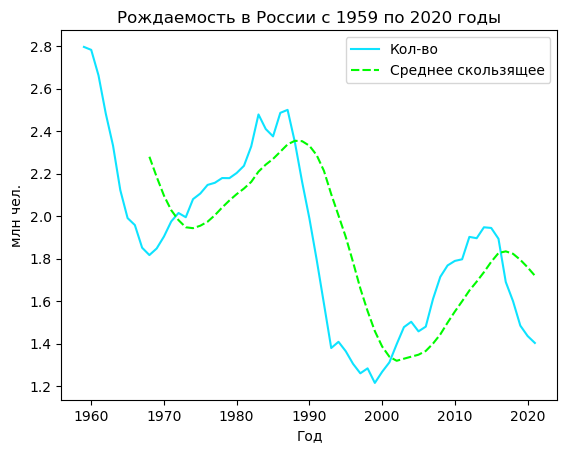

In [171]:
ax = sns.lineplot(data=df, palette=colors)
ax.set(title=parsed_data['caption'],
       xlabel='Год', 
       ylabel='млн чел.')
plt.legend(['Кол-во', 'Среднее скользящее'])
plt.show()